In [21]:
!pip install tensorflow_ranking
!pip install adversarial-robustness-toolbox
!pip uninstall numpy
!pip install numpy==1.23.5
!pip install keras==2.12
!pip install tensorflow-serving-api==2.12.0
!pip install tensorflow==2.12

  Using cached numpy-1.23.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0.7
    Uninstalling flatbuffers-2.0.7:
      Successfully uninstalled flatbuffers-2.0.7
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
   

Found existing installation: numpy 1.23.2
Uninstalling numpy-1.23.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.23.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.23.2
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-ranking 0.5.2 requires numpy==1.23.2, but you have numpy 1.23.5 which is incompatible.
tf2onnx 1.14.0 requires flatb

In [18]:
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.initializers import GlorotUniform
import tensorflow as tf
import tensorflow_ranking as tfr
import tf2onnx
import numpy as np
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [2]:
import sys
sys.path.append(sys.path.append('/content/drive/My Drive/CURIS/VeriX/train_networks'))

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tf.compat.v1.disable_eager_execution()

In [5]:
SEED = 137
output_path = 'drive/MyDrive/CURIS/VeriX/networks/'

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
import matplotlib.pyplot as plt
def plot_figure(image, path=None, cmap=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [-0.5, -0.5, 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(image, cmap=cmap)
    if path is not None:
      plt.savefig(path, bbox_inches='tight')
    # plt.close(fig)

In [28]:
def eval_and_save(model):
  score = model.evaluate(x_test, y_test, verbose=0)
  print("Test loss:", score[0])
  print("Test accuracy:", score[1])
  model.summary()
  model.save(output_path + model.name + '.h5')
  # model_proto, _ = tf2onnx.convert.from_keras(model, output_path=output_path + model.name + '.onnx')

In [9]:
def print_weights(model):
  for layer in model.layers:
    print(layer.get_config())
    print(layer.get_weights())

In [25]:
def train_pgd(model_pgd, num_epochs, alpha):
  art_model_pgd = KerasClassifier(model_pgd, clip_values=(0, 1))
  art_model_pgd.fit(x_train, y_train,
              batch_size=128,
              nb_epochs=1,
              verbose=1,
              validation_data=(x_test, y_test))
  pgd_attack = ProjectedGradientDescent(art_model_pgd, eps=0.1, eps_step=0.01, max_iter=10, verbose=False)

  num_samples = len(x_train)
  num_adv = int(num_samples * alpha)
  num_real = num_samples - num_adv

  for i in range(num_epochs - 1):
    adv_indices = np.random.choice(x_train.shape[0], size=num_adv, replace=False)
    real_indices = np.random.choice(x_train.shape[0], size=num_real, replace=False)
    adv_samples = pgd_attack.generate(
        x_train[adv_indices],
        batch_size=128)
    x_real = x_train[real_indices]
    y_real = y_train[real_indices]
    x_adv = np.concatenate((adv_samples, x_real))
    y_adv = np.concatenate((y_train[adv_indices], y_real))
    permutation = np.random.permutation(num_samples)
    x_adv = x_adv[permutation]
    y_adv = y_adv[permutation]
    art_model_pgd.fit(x_adv, y_adv,
              batch_size=128,
              nb_epochs=1,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model_pgd.evaluate(adv_samples, y_train[adv_indices])
    print(f'adv train loss: {score[0]} train acc: {score[1]}')

In [35]:
def evaluate(model, model_adv):
  print('Test loss and accuracy on original test data:')
  print('Regular model:')
  print(model.evaluate(x_test, y_test))
  print('Adv model:')
  print(model_adv.evaluate(x_test, y_test))
  print('')

  print('Test loss and accuracy on adv samples from regular model:')
  art_model_regular_pgd = KerasClassifier(model, clip_values=(0, 1))
  # pgd_attack_regular = ProjectedGradientDescent(art_model_regular_pgd, eps=0.1, eps_step=0.01, max_iter=50, verbose=False)
  # adv = pgd_attack_regular.generate(x_test, batch_size=128)
  fgm_attack_regular = FastGradientMethod(art_model_regular_pgd)
  adv = fgm_attack_regular.generate(x_test, batch_size=128)
  print('Regular model:')
  print(model.evaluate(adv, y_test))
  print('Adv model:')
  print(model_adv.evaluate(adv, y_test))
  print('')

  print('Test loss and accuracy on adv samples from adv model:')
  art_model_adv_pgd = KerasClassifier(model_adv, clip_values=(0, 1))
  # pgd_attack_adv = ProjectedGradientDescent(art_model_adv_pgd, eps=0.1, eps_step=0.01, max_iter=50, verbose=False)
  # adv = pgd_attack_adv.generate(x_test, batch_size=128)
  fgm_attack_adv = FastGradientMethod(art_model_adv_pgd)
  adv = fgm_attack_adv.generate(x_test, batch_size=128)
  print('Regular model:')
  print(model.evaluate(adv, y_test))
  print('Adv model:')
  print(model_adv.evaluate(adv, y_test))

10x2 fully connected

In [37]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [38]:
# normally trained model for compariaon
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(10, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-10x2-normal')
model.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.8568 - accuracy: 0.7497 - val_loss: 0.4422 - val_accuracy: 0.8704
Epoch 2/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.3886 - accuracy: 0.8885 - val_loss: 0.3421 - val_accuracy: 0.9017
Epoch 3/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3279 - accuracy: 0.9059 - val_loss: 0.3061 - val_accuracy: 0.9132
Epoch 4/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.2962 - accuracy: 0.9162 - val_loss: 0.2836 - val_accuracy: 0.9188
Epoch 5/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.2739 - accuracy: 0.9230 - val_loss: 0.2630 - val_accuracy: 0.9238
Epoch 6/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.2573 - accuracy: 0.9266 - val_loss: 0.2558 - val_accuracy: 0.9259
Epoch 7/20
60000/60000 [==============================] 

In [31]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(10, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-10x2-pgd')
model_pgd.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [39]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 31us/sample - loss: 0.3376 - accuracy: 0.9051 - val_loss: 0.3061 - val_accuracy: 0.9147
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 31us/sample - loss: 0.5151 - accuracy: 0.8595 - val_loss: 0.2961 - val_accuracy: 0.9169
adv train loss: 0.3165614689906438 train acc: 0.9095333218574524
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 30us/sample - loss: 0.4866 - accuracy: 0.8609 - val_loss: 0.2833 - val_accuracy: 0.9198
adv train loss: 0.3127591758966446 train acc: 0.9099000096321106
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 20us/sample - loss: 0.4684 - accuracy: 0.8670 - val_loss: 0.2754 - val_accuracy: 0.9214
adv train loss: 0.33213509452740353 train acc: 0.9035666584968567
Train on 60000 samples, validate on 10000 samples
60

In [40]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.21277001615911723, 0.9395]
Adv model:
[0.24793667847812176, 0.9285]

Test loss and accuracy on adv samples from regular model:
Regular model:
[35.520732318115236, 0.0214]
Adv model:
[5.187736444854736, 0.0859]

Test loss and accuracy on adv samples from adv model:
Regular model:
[17.432188684082032, 0.0472]
Adv model:
[14.042941835021972, 0.024]


In [41]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.21277001615911723
Test accuracy: 0.9395
Model: "mnist-10x2-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 logit (Dense)               (None, 10)                110       
                                                                 
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
____________________________________________________________

30x2 fully connected

In [ ]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [42]:
# normally trained model for compariaon
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(30, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(30, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-30x2-normal')
model.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.5124 - accuracy: 0.8558 - val_loss: 0.2303 - val_accuracy: 0.9347
Epoch 2/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2104 - accuracy: 0.9400 - val_loss: 0.1820 - val_accuracy: 0.9447
Epoch 3/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1671 - accuracy: 0.9517 - val_loss: 0.1636 - val_accuracy: 0.9515
Epoch 4/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.1431 - accuracy: 0.9586 - val_loss: 0.1458 - val_accuracy: 0.9584
Epoch 5/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.1269 - accuracy: 0.9628 - val_loss: 0.1337 - val_accuracy: 0.9623
Epoch 6/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.1136 - accuracy: 0.9668 - val_loss: 0.1284 - val_accuracy: 0.9644
Epoch 7/20
60000/60000 [==============================] 

In [43]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(30, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(30, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-30x2-pgd')
model_pgd.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [44]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 24us/sample - loss: 0.5193 - accuracy: 0.8519 - val_loss: 0.2406 - val_accuracy: 0.9289
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3063 - accuracy: 0.9090 - val_loss: 0.1998 - val_accuracy: 0.9429
adv train loss: 0.19905099148750305 train acc: 0.9410333037376404
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3871 - accuracy: 0.8896 - val_loss: 0.1743 - val_accuracy: 0.9476
adv train loss: 0.19209390201965967 train acc: 0.9446333050727844
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.2975 - accuracy: 0.9109 - val_loss: 0.1559 - val_accuracy: 0.9511
adv train loss: 0.17202934294541677 train acc: 0.9508666396141052
Train on 60000 samples, validate on 10000 samples


In [45]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.11829419829172548, 0.9696]
Adv model:
[0.11145895309951157, 0.9669]

Test loss and accuracy on adv samples from regular model:
Regular model:
[37.91198641357422, 0.0196]
Adv model:
[2.174595686149597, 0.4056]

Test loss and accuracy on adv samples from adv model:
Regular model:
[11.56554037322998, 0.1521]
Adv model:
[14.929519357299805, 0.0138]


In [46]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.11829419829172548
Test accuracy: 0.9696
Model: "mnist-30x2-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 30)                23550     
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 logit (Dense)               (None, 10)                310       
                                                                 
Total params: 24,790
Trainable params: 24,790
Non-trainable params: 0
__________________________________________________________

100x2 fully connected

In [2]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [47]:
# normally trained model for compariaon
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(100, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(100, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-100x2-normal')
model.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.3409 - accuracy: 0.9020 - val_loss: 0.1795 - val_accuracy: 0.9455
Epoch 2/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.1399 - accuracy: 0.9587 - val_loss: 0.1216 - val_accuracy: 0.9630
Epoch 3/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0978 - accuracy: 0.9704 - val_loss: 0.1003 - val_accuracy: 0.9675
Epoch 4/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0749 - accuracy: 0.9771 - val_loss: 0.0893 - val_accuracy: 0.9709
Epoch 5/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0593 - accuracy: 0.9819 - val_loss: 0.0879 - val_accuracy: 0.9726
Epoch 6/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0482 - accuracy: 0.9843 - val_loss: 0.0891 - val_accuracy: 0.9731
Epoch 7/20
60000/60000 [==============================] 

In [48]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(100, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(100, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-100x2-pgd')
model_pgd.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [49]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 38us/sample - loss: 0.3485 - accuracy: 0.8993 - val_loss: 0.1720 - val_accuracy: 0.9490
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.2155 - accuracy: 0.9358 - val_loss: 0.1238 - val_accuracy: 0.9623
adv train loss: 0.11473088092257579 train acc: 0.9653000235557556
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 34us/sample - loss: 0.2434 - accuracy: 0.9307 - val_loss: 0.1162 - val_accuracy: 0.9643
adv train loss: 0.10867337775677442 train acc: 0.9684000015258789
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.1843 - accuracy: 0.9484 - val_loss: 0.0990 - val_accuracy: 0.9704
adv train loss: 0.09152162838528553 train acc: 0.972599983215332
Train on 60000 samples, validate on 10000 samples
6

In [50]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.10720364366221183, 0.9769]
Adv model:
[0.0680444527752581, 0.9778]

Test loss and accuracy on adv samples from regular model:
Regular model:
[35.847421008300785, 0.0311]
Adv model:
[1.3557057939052581, 0.599]

Test loss and accuracy on adv samples from adv model:
Regular model:
[9.888806645202637, 0.1419]
Adv model:
[17.42983818359375, 0.0171]


In [51]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.10720364366221183
Test accuracy: 0.9769
Model: "mnist-100x2-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 logit (Dense)               (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________

cnn-simple

In [52]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(4, (3, 3), name='conv_1', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(4, (2, 2), strides=(2, 2), name='conv_2', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Flatten()(x)
x = Dense(20, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='mnist-simple-cnn-normal')

model.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 134us/sample - loss: 0.5132 - accuracy: 0.8463 - val_loss: 0.2605 - val_accuracy: 0.9250
Epoch 2/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2464 - accuracy: 0.9289 - val_loss: 0.2229 - val_accuracy: 0.9357
Epoch 3/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2163 - accuracy: 0.9367 - val_loss: 0.1968 - val_accuracy: 0.9431
Epoch 4/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1961 - accuracy: 0.9431 - val_loss: 0.1827 - val_accuracy: 0.9500
Epoch 5/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1795 - accuracy: 0.9478 - val_loss: 0.1795 - val_accuracy: 0.9478
Epoch 6/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.1670 - accuracy: 0.9515 - val_loss: 0.1721 - val_accuracy: 0.9490
Epoch 7/20
60000/60000 [==============================]

In [53]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(4, (3, 3), name='conv_1', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(4, (2, 2), strides=(2, 2), name='conv_2', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Flatten()(x)
x = Dense(20, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=x, name='mnist-simple-cnn-pgd')

model_pgd.compile(# loss='categorical_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [54]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 3s 43us/sample - loss: 0.5137 - accuracy: 0.8450 - val_loss: 0.2625 - val_accuracy: 0.9267
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 28us/sample - loss: 0.4068 - accuracy: 0.8761 - val_loss: 0.2608 - val_accuracy: 0.9228
adv train loss: 0.2736689247151216 train acc: 0.9194333553314209
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4150 - accuracy: 0.8756 - val_loss: 0.2112 - val_accuracy: 0.9388
adv train loss: 0.23954009110331537 train acc: 0.9315333366394043
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4006 - accuracy: 0.8777 - val_loss: 0.2047 - val_accuracy: 0.9413
adv train loss: 0.2569413528243701 train acc: 0.9260333180427551
Train on 60000 samples, validate on 10000 samples
60

In [55]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.1402775631153956, 0.9617]
Adv model:
[0.1358160742379725, 0.957]

Test loss and accuracy on adv samples from regular model:
Regular model:
[30.704048516845702, 0.0203]
Adv model:
[3.211679522705078, 0.2333]

Test loss and accuracy on adv samples from adv model:
Regular model:
[9.01954021911621, 0.1164]
Adv model:
[15.926033908081054, 0.0269]


In [56]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.1402775631153956
Test accuracy: 0.9617
Model: "mnist-simple-cnn-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 conv_2 (Conv2D)             (None, 13, 13, 4)         68        
                                                                 
 flatten_9 (Flatten)         (None, 676)               0         
                                                                 
 dense (Dense)               (None, 20)                13540     
                                                                 
 logit (Dense)               (None, 10)                210       
                                                         

cnn-sota

In [ ]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [ ]:
# normally trained model for comparision

inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dropout(0.5, seed=SEED)(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-sota-normal')
model.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9254

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 12s 192us/sample - loss: 0.2401 - accuracy: 0.9254 - val_loss: 0.0422 - val_accuracy: 0.9859
Epoch 2/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0690 - accuracy: 0.9798 - val_loss: 0.0367 - val_accuracy: 0.9889
Epoch 3/20
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0482 - accuracy: 0.9862 - val_loss: 0.0205 - val_accuracy: 0.9932
Epoch 4/20
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0236 - val_accuracy: 0.9932
Epoch 5/20
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0257 - val_accuracy: 0.9925
Epoch 6/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0272 - accuracy: 0.9914 - val_loss: 0.0272 - val_accuracy: 0.9931
Epoch 7/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0238 - accuracy: 0.9926 - val_lo

In [ ]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dropout(0.5, seed=SEED)(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-sota-pgd')
model_pgd.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [ ]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
59904/60000 [============================>.] - ETA: 0s - loss: 0.2339 - accuracy: 0.9265

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 4s 72us/sample - loss: 0.2336 - accuracy: 0.9266 - val_loss: 0.0420 - val_accuracy: 0.9869


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0874 - accuracy: 0.9732 - val_loss: 0.0300 - val_accuracy: 0.9901
adv train loss: 0.030231569734541698 train acc: 0.9902999997138977
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0540 - accuracy: 0.9844 - val_loss: 0.0230 - val_accuracy: 0.9928
adv train loss: 0.02148217306341588 train acc: 0.9935666918754578
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0529 - accuracy: 0.9845 - val_loss: 0.0208 - val_accuracy: 0.9931
adv train loss: 0.016763980462714486 train acc: 0.9946666955947876
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0427 - accuracy: 0.9875 - val_loss: 0.0238 - val_accuracy: 0.9920
adv train loss: 0.01356623228554769 train acc: 0

In [ ]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.025107924216459982, 0.9947]
Adv model:
[0.02079905009451977, 0.9944]

Test loss and accuracy on adv samples from regular model:


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Regular model:
[2.2156280811309816, 0.5203]
Adv model:
[0.6746757946014404, 0.7902]

Test loss and accuracy on adv samples from adv model:
Regular model:
[0.32085431804656983, 0.902]
Adv model:
[1.0280582367897033, 0.7158]


In [ ]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.025107924216459982
Test accuracy: 0.9947
Model: "mnist-sota-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928 

In [ ]:
inp = Input(shape=(28, 28, 1))
x = Flatten()(inp)
x = Dense(10, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)

model_test = tf.keras.Model(inputs=inp, outputs=x)
model_test.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
              metrics=['accuracy'])

art_model_test = KerasClassifier(model=model, clip_values=(0, 1))
mini_batch_size = 50
pgd_attack = ProjectedGradientDescent(art_model_test,
                                      eps=0.1,
                                      eps_step=0.005,
                                      max_iter=40,
                                      batch_size=mini_batch_size)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

[-24.668528]


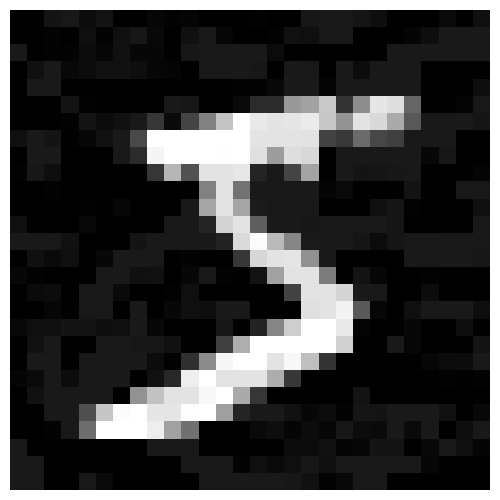

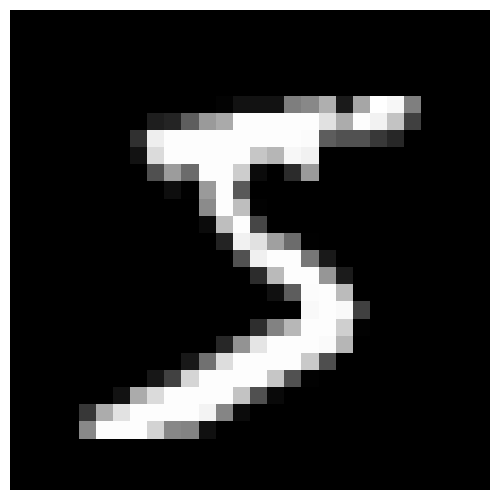

In [ ]:
adv = pgd_attack.generate(x_train[:10], batch_size=32)
plot_figure(adv[0], cmap='gray')
plot_figure(x_train[0], cmap='gray')
print(sum(sum(x_train[0] - adv[0])))